<h1 align="center"><font color="yellow">LangChain: QA over Documents</font></h1>

<font color="yellow">Data Scientist.: Dr.Eddy Giusepe Chirinos Isidro</font>

Links de estudo:

* [LangChain: QA over Documents](https://python.langchain.com/docs/use_cases/question_answering)

* [Harnessing Retrieval Augmented Generation With Langchain](https://betterprogramming.pub/harnessing-retrieval-augmented-generation-with-langchain-2eae65926e82)

* [Researching a Multilingual FEMA Disaster Bot Using LangChain and GPT-4](https://towardsdatascience.com/researching-a-multilingual-fema-disaster-bot-using-langchain-and-gpt-4-4591f26d8dcd)



Suponha que você tenha alguns documentos de texto (PDF, blog, páginas do Notion, etc.) e queira fazer perguntas relacionadas ao conteúdo desses documentos. Os `LLMs`, devido à sua proficiência na compreensão de texto, são uma ótima ferramenta para isso.

Neste passo a passo, veremos como criar um aplicativo de resposta a perguntas sobre documentos usando `LLMs`. Dois casos de uso muito relacionados que abordamos em outro lugar são:

* QA sobre dados estruturados (`por exemplo, SQL`)

* QA sobre código (`por exemplo, Python`)

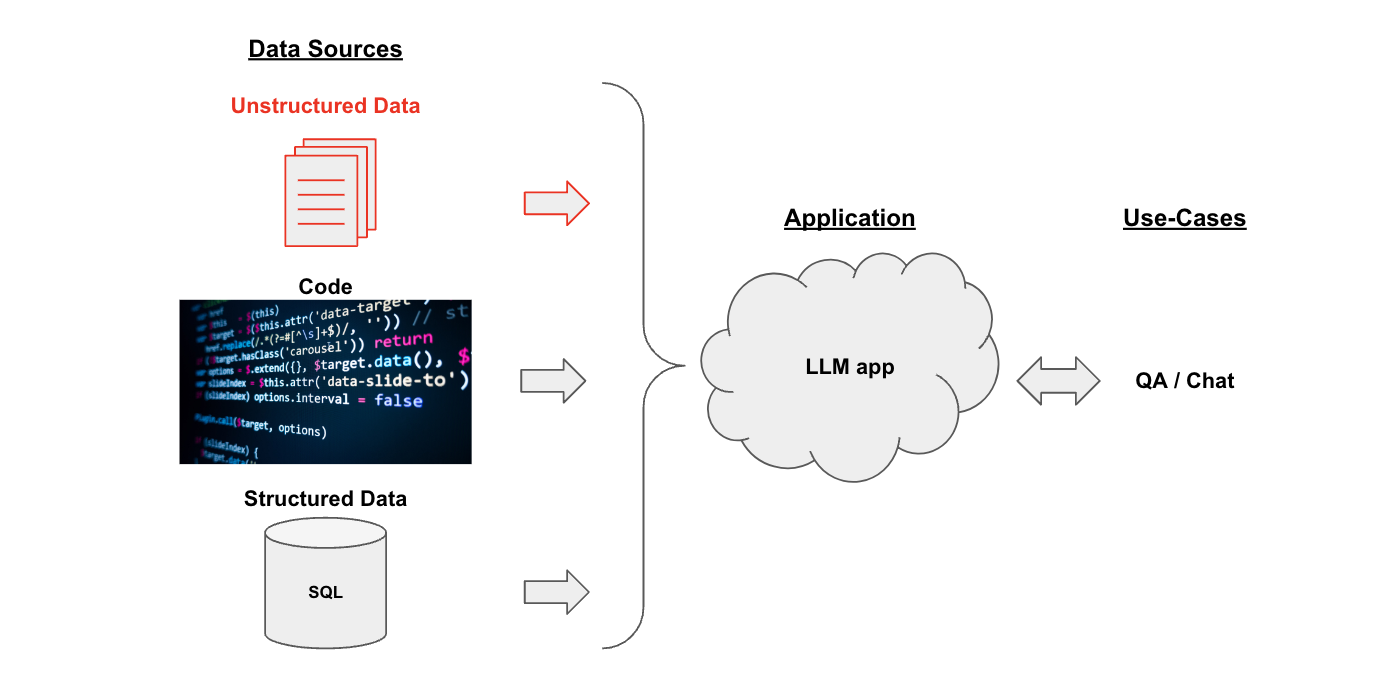

O pipeline para converter dados brutos não estruturados em uma cadeia de controle de qualidade tem a seguinte aparência:

* `Loading:` Primeiro precisamos carregar nossos dados. Dados não estruturados podem ser carregados de várias fontes. Use o `hub de integração LangChain` para navegar pelo conjunto completo de carregadores. Cada carregador retorna dados como um LangChain `Document`.

* `Splitting:` divisores de texto dividem-se Document sem divisões de tamanho especificado

* `Storage:` Storage (por exemplo, `geralmente um vectorstore` ) abrigará e geralmente incorporará as divisões

* `Retrieval:` o aplicativo recupera divisões do armazenamento (por exemplo, `geralmente com Embeddings semelhantes à pergunta de entrada`)

* `Generation:` Um `LLM` produz uma resposta usando um `prompt` que inclui a pergunta e os dados recuperados

* `Conversation` (Extensão): mantenha uma conversa de vários turnos adicionando `Memória` à sua cadeia de QA.

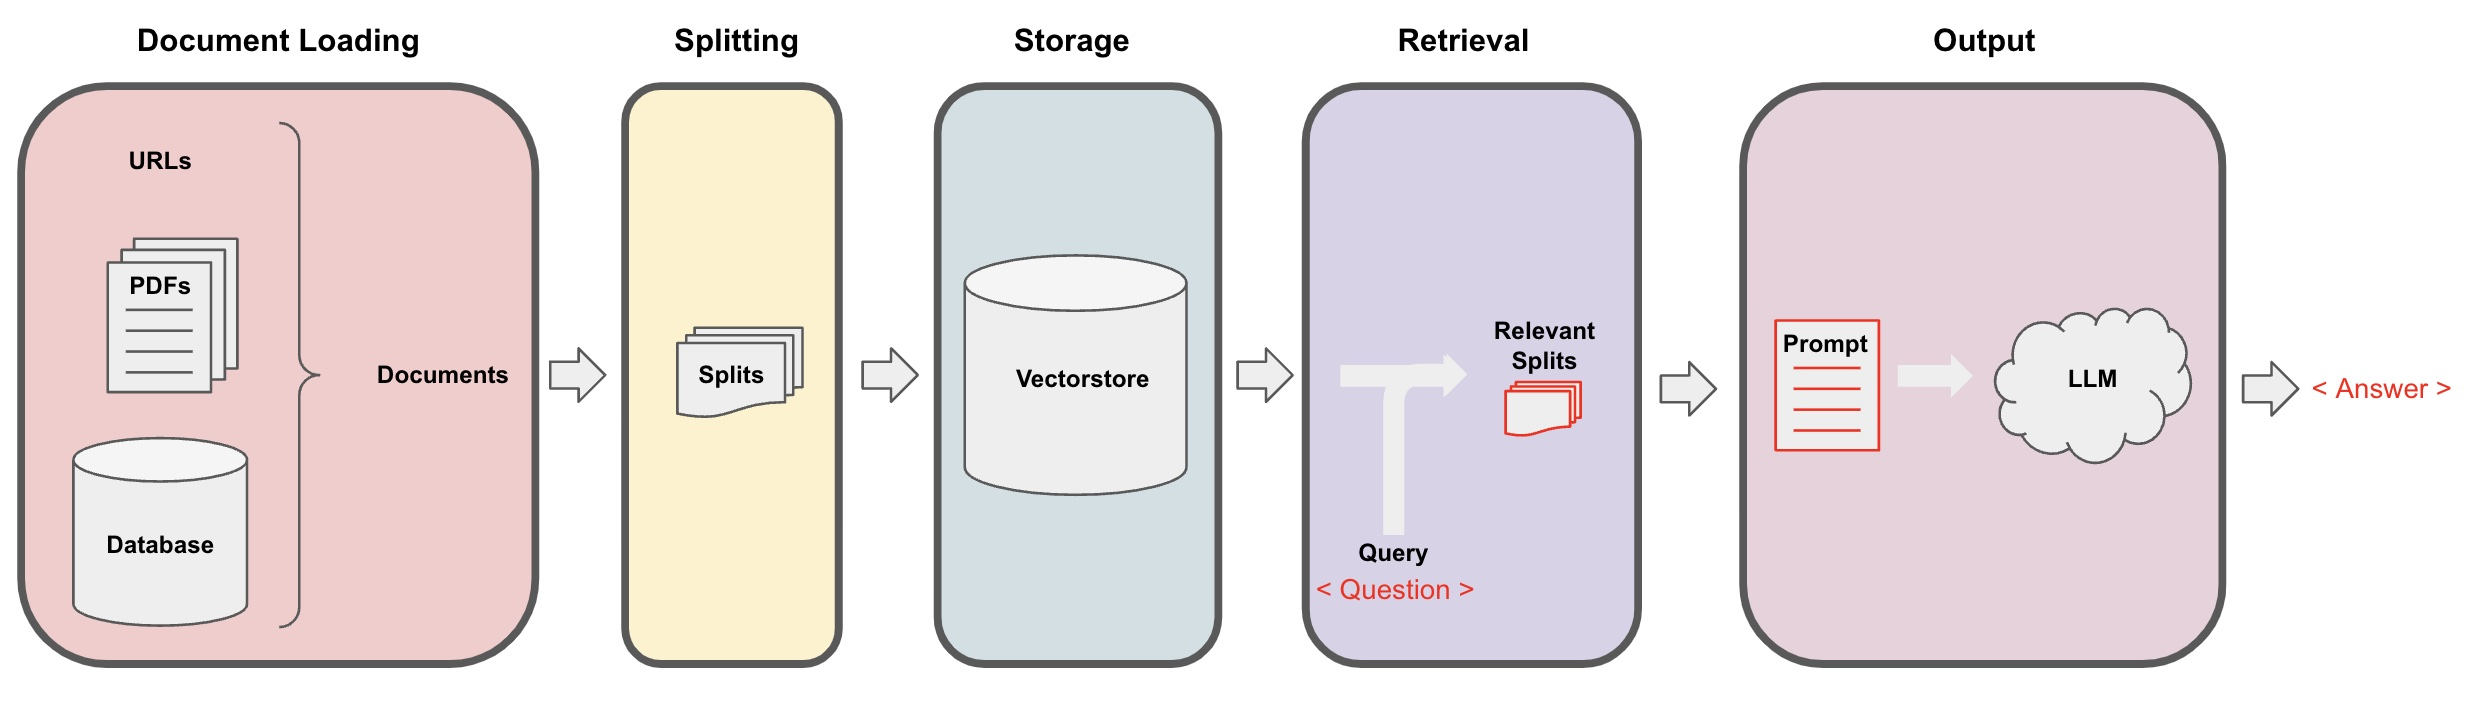

Para dar uma prévia, o pipeline acima pode ser todo agrupado em um único objeto: `VectorstoreIndexCreator`. Suponha que queremos um aplicativo de `QA` sobre esta `postagem do blog` [Agentes autônomos com tecnologia LLM](https://lilianweng.github.io/posts/2023-06-23-agent/). Podemos criar isso em algumas linhas de código:

Primeiro defina as variáveis ​​de ambiente e instale os pacotes:

In [16]:
%pip install openai chromadb

Note: you may need to restart the kernel to use updated packages.


In [17]:
import os
import openai
import tiktoken
from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv()) # read local .env file

openai.api_key  = os.environ['OPENAI_API_KEY']


In [18]:
from langchain.document_loaders import WebBaseLoader
from langchain.indexes import VectorstoreIndexCreator

loader = WebBaseLoader("https://lilianweng.github.io/posts/2023-06-23-agent/")
index = VectorstoreIndexCreator().from_loaders([loader])


In [19]:
index

VectorStoreIndexWrapper(vectorstore=<langchain.vectorstores.chroma.Chroma object at 0x7fc307097070>)

<font color="orange">Agora você pode perguntar e assim tirar as suas dúvidas:</font>

In [20]:
index.query("O que é Decomposição de Tarefas?")

' Decomposição de tarefas é o processo de dividir uma tarefa complexa em tarefas menores e mais simples. Pode ser feito usando LLM com prompts simples, instruções específicas da tarefa ou com ajuda humana.'

In [21]:
index.query("O que é Auto-reflexão?")

' Auto-reflexão é um aspecto vital que permite que agentes autônomos melhorem iterativamente, refinando decisões de ação passadas e corrigindo erros anteriores. Desempenha um papel crucial em tarefas do mundo real onde o ensaio e erro são inevitáveis.'

<font color="pink">Ok, mas o que está acontecendo nos bastidores e como poderíamos personalizar isso para nosso caso de uso específico? Para isso, vamos dar uma olhada em como podemos construir esse pipeline peça por peça.</font>

# <font color="red">Etapa 1: Carregar</font>

Especifique um `DocumentLoader` para carregar seus dados `não estruturados` como `Documents`. A `Document` é um pedaço de texto (o `page_content`) e metadados associados.

In [22]:
from langchain.document_loaders import WebBaseLoader

loader = WebBaseLoader("https://lilianweng.github.io/posts/2023-06-23-agent/")
data = loader.load()


# Carregador de Dados --> https://integrations.langchain.com/

# <font color="red">Etapa 2: Dividir</font>

Divida (`split`) o `Document` em pedaços para Embedding e armazenamento de vetores.

In [23]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(chunk_size = 500, chunk_overlap = 0)
all_splits = text_splitter.split_documents(data)


# Você pode printar "all_splits" e ver o Document e o page_content, a qual contém as informações do Blog.

# <font color="red">Etapa 3: Armazenar</font>

Para poder consultar nossas divisões de documentos, primeiro precisamos armazená-los onde possamos procurá-los posteriormente. A maneira mais comum de fazer isso é incorporar o conteúdo de cada documento e, em seguida, armazenar os Embeddings e o documento em um armazenamento de `vetores`, com os Embeddings sendo usado para indexar o documento.

In [24]:
from langchain.embeddings import OpenAIEmbeddings
from langchain.vectorstores import Chroma


vectorstore = Chroma.from_documents(documents=all_splits, embedding=OpenAIEmbeddings())

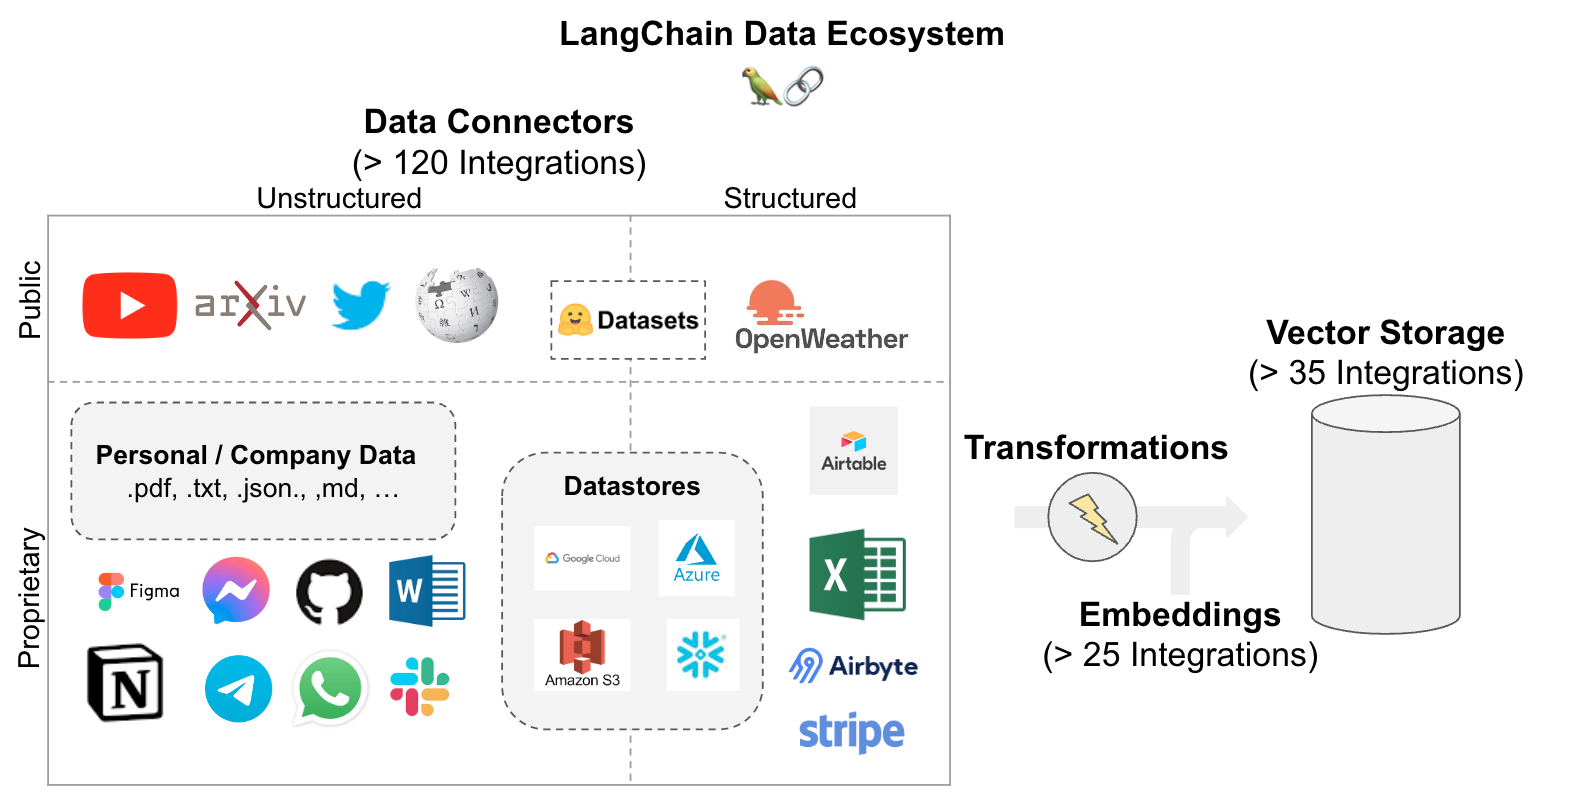

# <font color="red">Etapa 4: Retrieve (Recuperar)</font>

Recupere divisões relevantes para qualquer pergunta usando a [pesquisa por similaridade](https://www.pinecone.io/learn/what-is-similarity-search/).

In [25]:
question = "Quais são as abordagens para Decomposição de Tarefas?"

docs = vectorstore.similarity_search(query=question,
                                     k=3
                                    )

docs

[Document(page_content='Task decomposition can be done (1) by LLM with simple prompting like "Steps for XYZ.\\n1.", "What are the subgoals for achieving XYZ?", (2) by using task-specific instructions; e.g. "Write a story outline." for writing a novel, or (3) with human inputs.', metadata={'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview In a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:', 'language': 'en', 'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'title': "LLM Powered Autonomous Agents | Lil'Log"}),
 Document(page_content='Task decomposition can be done (1) by 

<font color="orange">`Vectorstores` são comumente usados ​​para recuperação, mas não são a única opção. Por exemplo, SVMs (veja o tópico [aqui](https://twitter.com/karpathy/status/1647025230546886658?s=20)) também podem ser usados.

LangChain [tem muitos retrievers](https://python.langchain.com/docs/modules/data_connection/retrievers/), incluindo, mas não limitado a, vectorstores. Todos os recuperadores implementam um método comum `get_relevant_documents()`(e sua variante `assíncrona aget_relevant_documents()`).</font>

In [26]:
# from langchain.retrievers import SVMRetriever

# svm_retriever = SVMRetriever.from_documents(all_splits,
#                                             OpenAIEmbeddings()
#                                            )

# docs_svm = svm_retriever.get_relevant_documents(query=question)

# docs_svm

Outras maneiras de melhorar a pesquisa por similaridade vetorial:

In [29]:
# import logging

# from langchain.chat_models import ChatOpenAI
# from langchain.retrievers.multi_query import MultiQueryRetriever # Gera queries a partir da query original --> https://python.langchain.com/docs/modules/data_connection/retrievers/MultiQueryRetriever


# logging.basicConfig()
# logging.getLogger('langchain.retrievers.multi_query').setLevel(logging.INFO)


# retriever_from_llm = MultiQueryRetriever.from_llm(retriever=vectorstore.as_retriever(),
#                                                   llm=ChatOpenAI(temperature=0)
#                                                  )

In [30]:
#retriever_from_llm

NameError: name 'retriever_from_llm' is not defined

In [29]:
#retriever_from_llm.llm_chain

In [30]:
#retriever_from_llm.llm_chain.output_parser

In [31]:
# retriever_from_llm.llm_chain.prompt

PromptTemplate(input_variables=['question'], output_parser=None, partial_variables={}, template='You are an AI language model assistant. Your task is \n    to generate 3 different versions of the given user \n    question to retrieve relevant documents from a vector  database. \n    By generating multiple perspectives on the user question, \n    your goal is to help the user overcome some of the limitations \n    of distance-based similarity search. Provide these alternative \n    questions separated by newlines. Original question: {question}', template_format='f-string', validate_template=True)

In [32]:
# print(retriever_from_llm.llm_chain.prompt.template)

You are an AI language model assistant. Your task is 
    to generate 3 different versions of the given user 
    question to retrieve relevant documents from a vector  database. 
    By generating multiple perspectives on the user question, 
    your goal is to help the user overcome some of the limitations 
    of distance-based similarity search. Provide these alternative 
    questions separated by newlines. Original question: {question}


In [33]:
# Aqui printo as trê perguntas geradas com o PROMPT:
# unique_docs = retriever_from_llm.get_relevant_documents(query=question)

INFO:langchain.retrievers.multi_query:Generated queries: ['Quais são os diferentes métodos de Decomposição de Tarefas?', 'Quais são as estratégias utilizadas na Decomposição de Tarefas?', 'Quais são as técnicas comumente empregadas na Decomposição de Tarefas?']


In [34]:
# unique_docs

[Document(page_content='Task decomposition can be done (1) by LLM with simple prompting like "Steps for XYZ.\\n1.", "What are the subgoals for achieving XYZ?", (2) by using task-specific instructions; e.g. "Write a story outline." for writing a novel, or (3) with human inputs.', metadata={'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview In a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:', 'language': 'en', 'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'title': "LLM Powered Autonomous Agents | Lil'Log"}),
 Document(page_content='Tree of Thoughts (Yao et al. 2023) ext

# <font color="red">Etapa 5: Generate (Gerar)</font>

Destilar os documentos recuperados em uma resposta usando um modelo `LLM/Chat` (por exemplo, `gpt-3.5-turbo`) com a cadeia `RetrievalQA`.

In [35]:
from langchain.chains import RetrievalQA
from langchain.chat_models import ChatOpenAI


llm = ChatOpenAI(model_name="gpt-3.5-turbo", temperature=0)

qa_chain = RetrievalQA.from_chain_type(llm,
                                       retriever=vectorstore.as_retriever()
                                      )


qa_chain({"query": question})

{'query': 'Quais são as abordagens para Decomposição de Tarefas?',
 'result': 'As abordagens para decomposição de tarefas incluem:\n\n1) Utilizando modelos de linguagem com prompts simples, como "Passos para XYZ.\\n1.", "Quais são os subobjetivos para alcançar XYZ?"\n\n2) Utilizando instruções específicas para a tarefa, como "Escreva um esboço de história" para escrever um romance.\n\n3) Com a entrada de seres humanos para auxiliar na decomposição da tarefa.'}

## <font color="yellow">Customizing the prompt</font>

<font color="orange">O `prompt` na `RetrievalQA` pode ser facilmente personalizado.</font>

In [36]:
from langchain.chains import RetrievalQA
from langchain.prompts import PromptTemplate


template = """Use as seguintes peças de contexto para responder à pergunta no final. \
              Se você não souber a resposta, apenas diga que não sabe, não tente inventar \
              uma resposta. Use três frases no máximo e mantenha a resposta o mais concisa possível. \
              Sempre diga "obrigado por perguntar!" no final da resposta. 
{context}
Question: {question}
Helpful Answer:"""

QA_CHAIN_PROMPT = PromptTemplate.from_template(template)

llm = ChatOpenAI(model_name="gpt-3.5-turbo",
                 temperature=0
                )


qa_chain = RetrievalQA.from_chain_type(llm,
                                       retriever=vectorstore.as_retriever(),
                                       chain_type_kwargs={"prompt": QA_CHAIN_PROMPT}
                                      )


result = qa_chain({"query": question})
result["result"]


'As abordagens para decomposição de tarefas incluem o uso de LLM com prompts simples, instruções específicas para a tarefa e inputs humanos. Obrigado por perguntar!'

## <font color="yellow">Return source documents</font>

O conjunto completo de documentos recuperados usados ​​para destilação de resposta pode ser retornado usando `return_source_documents=True`.

In [37]:
from langchain.chains import RetrievalQA

qa_chain = RetrievalQA.from_chain_type(llm,
                                       retriever=vectorstore.as_retriever(),
                                       return_source_documents=True
                                      )

result = qa_chain({"query": question}) # question = "Quais são as abordagens para Decomposição de Tarefas?"

result['source_documents']
      

[Document(page_content='Task decomposition can be done (1) by LLM with simple prompting like "Steps for XYZ.\\n1.", "What are the subgoals for achieving XYZ?", (2) by using task-specific instructions; e.g. "Write a story outline." for writing a novel, or (3) with human inputs.', metadata={'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview In a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:', 'language': 'en', 'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'title': "LLM Powered Autonomous Agents | Lil'Log"}),
 Document(page_content='Task decomposition can be done (1) by 

In [38]:
result['source_documents'][0]

Document(page_content='Task decomposition can be done (1) by LLM with simple prompting like "Steps for XYZ.\\n1.", "What are the subgoals for achieving XYZ?", (2) by using task-specific instructions; e.g. "Write a story outline." for writing a novel, or (3) with human inputs.', metadata={'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview In a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:', 'language': 'en', 'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'title': "LLM Powered Autonomous Agents | Lil'Log"})

## <font color="yellow">Return citations</font>

Citações de respostas podem ser retornadas usando `RetrievalQAWithSourcesChain`.

In [39]:
from langchain.chains import RetrievalQAWithSourcesChain

qa_chain = RetrievalQAWithSourcesChain.from_chain_type(llm,
                                                       retriever=vectorstore.as_retriever()
                                                      )


result = qa_chain({"question": question})

result

{'question': 'Quais são as abordagens para Decomposição de Tarefas?',
 'answer': 'As abordagens para a decomposição de tarefas são: (1) por meio de LLM com instruções simples, como "Passos para XYZ. 1.", "Quais são os subobjetivos para alcançar XYZ?", (2) usando instruções específicas da tarefa, como "Escreva um esboço da história." para escrever um romance, ou (3) com entradas humanas. Além disso, o Tree of Thoughts (Yao et al. 2023) estende a abordagem de decomposição de tarefas, explorando múltiplas possibilidades de raciocínio em cada etapa e gerando múltiplos pensamentos por etapa, criando uma estrutura de árvore. O processo de busca pode ser BFS (busca em largura) ou DFS (busca em profundidade), com cada estado avaliado por um classificador (por meio de uma instrução) ou voto majoritário.\n',
 'sources': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}

## <font color="yellow">Customizing retrieved document processing (`Customizando o processamento de documentos recuperados`)</font>

<font color="orange">Os documentos recuperados podem ser alimentados a um `LLM` para destilação de resposta de algumas maneiras diferentes.</font>

`stuff`, `refine`, `map-reduce` e `map-rerank` as cadeias para passar documentos para um `prompt` do `LLM` estão bem resumidas [aqui](https://python.langchain.com/docs/modules/chains/document/).

`stuff` é comumente usado porque simplesmente "stuffs" (encher) todos os documentos recuperados no prompt.

O `load_qa_chain` é uma maneira fácil de passar documentos para um `LLM` usando essas várias abordagens (por exemplo, consulte `chain_type`).

In [40]:
from langchain.chains.question_answering import load_qa_chain

chain = load_qa_chain(llm,
                      chain_type="stuff"
                     )


#chain({"input_documents": unique_docs, "question": question}, return_only_outputs=False)

{'input_documents': [Document(page_content='Task decomposition can be done (1) by LLM with simple prompting like "Steps for XYZ.\\n1.", "What are the subgoals for achieving XYZ?", (2) by using task-specific instructions; e.g. "Write a story outline." for writing a novel, or (3) with human inputs.', metadata={'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview In a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:', 'language': 'en', 'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'title': "LLM Powered Autonomous Agents | Lil'Log"}),
  Document(page_content='Tree of Thoughts 

<font color="orange">Também podemos passar o `chain_type` para `RetrievalQA`.</font>

In [41]:
qa_chain = RetrievalQA.from_chain_type(llm,
                                       retriever=vectorstore.as_retriever(search_type="similarity_score_threshold",
                                                                          search_kwargs= {'k': 2,
                                                                                          'score_threshold':0.015}),
                                       chain_type="stuff"
                                      )


result = qa_chain({"query": question})


In [42]:
result

{'query': 'Quais são as abordagens para Decomposição de Tarefas?',
 'result': 'As abordagens para decomposição de tarefas incluem: (1) usar LLM com prompts simples como "Passos para XYZ.\\n1.", "Quais são os subobjetivos para alcançar XYZ?", (2) usar instruções específicas para a tarefa, como "Escreva um esboço de história." para escrever um romance, ou (3) com entradas humanas.'}

<font color="orange">Em resumo, o usuário pode escolher o nível de abstração desejado para `QA`:</font>

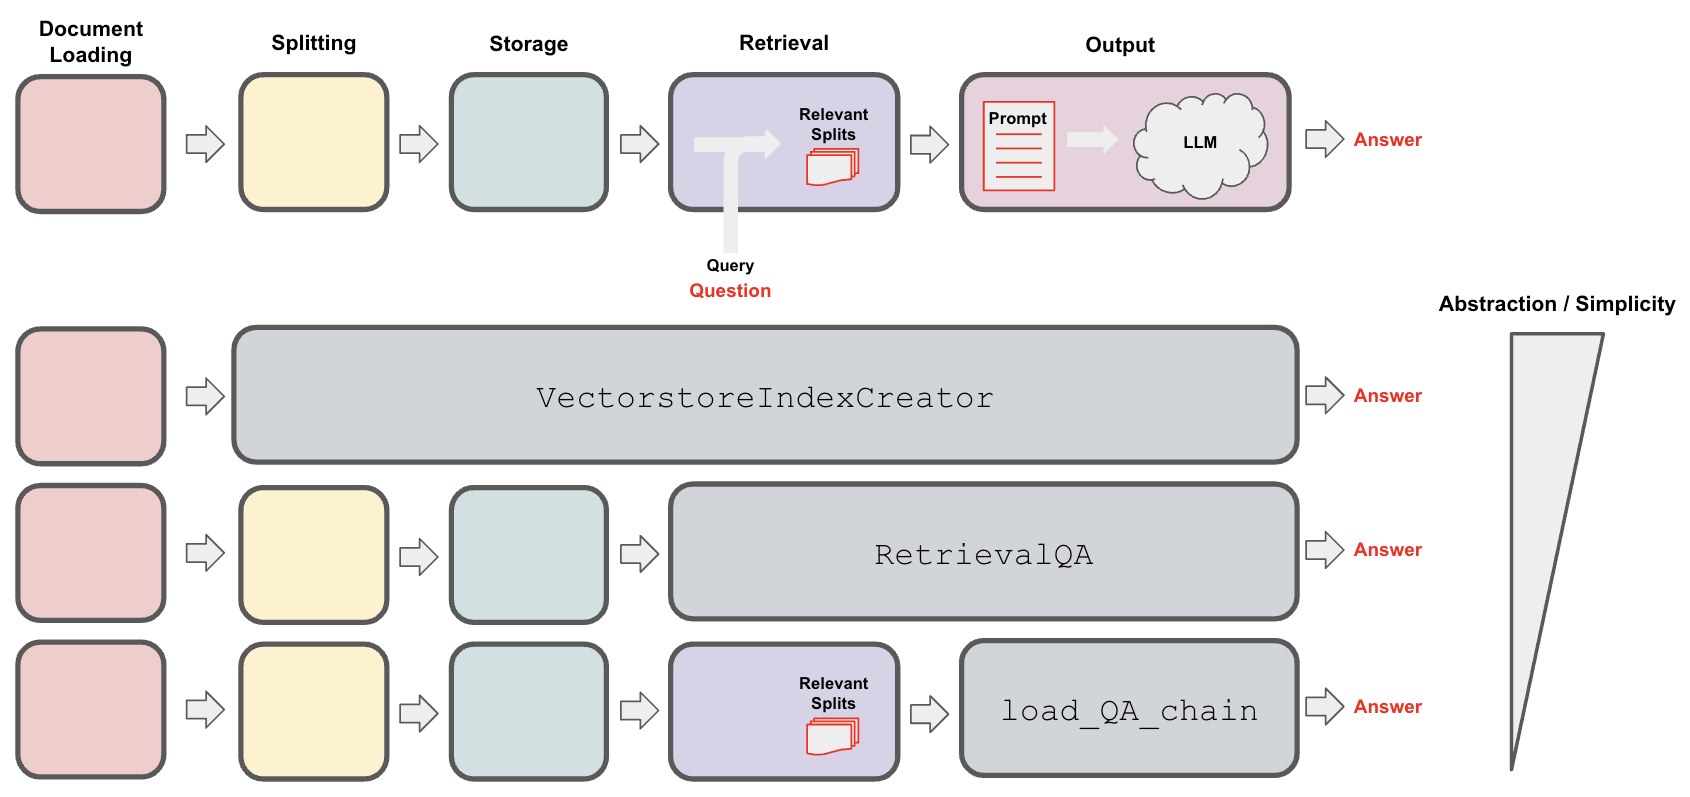

# <font color="red">Etapa 6: Converse (Extension)</font>

<font color="pink">Para manter uma conversa, uma cadeia precisa ser capaz de se referir a `interações passadas`. Chain `Memory` nos permite fazer isso. Para manter o histórico do bate-papo, podemos especificar um `buffer de memória` para rastrear as entradas/saídas da conversa.</font>

In [43]:
from langchain.memory import ConversationBufferMemory

memory = ConversationBufferMemory(memory_key="chat_history",
                                  return_messages=True
                                 )


In [44]:
memory

ConversationBufferMemory(chat_memory=ChatMessageHistory(messages=[]), output_key=None, input_key=None, return_messages=True, human_prefix='Human', ai_prefix='AI', memory_key='chat_history')

In [45]:
memory.load_memory_variables

<bound method ConversationBufferMemory.load_memory_variables of ConversationBufferMemory(chat_memory=ChatMessageHistory(messages=[]), output_key=None, input_key=None, return_messages=True, human_prefix='Human', ai_prefix='AI', memory_key='chat_history')>

In [46]:
memory.chat_memory

ChatMessageHistory(messages=[])

<font color="orange">O `ConversationalRetrievalChain` chat usa no `Memory buffer`.</font>

In [74]:
from langchain.chains import ConversationalRetrievalChain



retriever = vectorstore.as_retriever(search_type="similarity_score_threshold",
                                     search_kwargs= {'k': 2,
                                                     'score_threshold':0.015})

chat = ConversationalRetrievalChain.from_llm(llm,
                                             retriever=retriever,
                                             memory=memory,
                                             verbose=True                            
                                            )


In [75]:
result = chat({"question": "Quais são algumas das ideias principais na auto-reflexão?"})

result



> Entering new LLMChain chain...
Prompt after formatting:
Given the following conversation and a follow up question, rephrase the follow up question to be a standalone question, in its original language.

Chat History:

Human: Quais são algumas das ideias principais na auto-reflexão?
Assistant: Algumas das ideias principais na auto-reflexão são:

1. Melhoria contínua: A auto-reflexão permite que os agentes autônomos melhorem iterativamente, aprendendo com suas ações passadas e corrigindo erros.

2. Tomada de decisão: Através da auto-reflexão, os agentes podem analisar suas decisões passadas e avaliar sua eficácia, permitindo que façam escolhas mais informadas no futuro.

3. Aprendizado com erros: A auto-reflexão permite que os agentes identifiquem e corrijam erros cometidos anteriormente, evitando repeti-los no futuro.

4. Autoconsciência: Através da auto-reflexão, os agentes desenvolvem uma compreensão mais profunda de si mesmos, de suas habilidades e limitações, o que os ajuda a to

{'question': 'Quais são algumas das ideias principais na auto-reflexão?',
 'chat_history': [HumanMessage(content='Quais são algumas das ideias principais na auto-reflexão?', additional_kwargs={}, example=False),
  AIMessage(content='Algumas das ideias principais na auto-reflexão são:\n\n1. Melhoria contínua: A auto-reflexão permite que os agentes autônomos melhorem iterativamente, aprendendo com suas ações passadas e corrigindo erros.\n\n2. Tomada de decisão: Através da auto-reflexão, os agentes podem analisar suas decisões passadas e avaliar sua eficácia, permitindo que façam escolhas mais informadas no futuro.\n\n3. Aprendizado com erros: A auto-reflexão permite que os agentes identifiquem e corrijam erros cometidos anteriormente, evitando repeti-los no futuro.\n\n4. Autoconsciência: Através da auto-reflexão, os agentes desenvolvem uma compreensão mais profunda de si mesmos, de suas habilidades e limitações, o que os ajuda a tomar decisões mais adequadas.\n\n5. Adaptação: A auto-refl

In [76]:
result['answer']

'Algumas outras abordagens e conceitos relacionados à auto-reflexão incluem:\n\n1. Metacognição: A metacognição refere-se à capacidade de uma pessoa de pensar sobre seus próprios processos cognitivos, como pensamentos, conhecimentos e estratégias de aprendizagem. Envolve a consciência e o controle dos próprios processos mentais.\n\n2. Autoconsciência: A autoconsciência é a capacidade de uma pessoa de estar ciente de si mesma, de seus pensamentos, emoções, comportamentos e experiências. É um componente fundamental da auto-reflexão, pois permite que uma pessoa avalie e compreenda suas próprias ações e motivações.\n\n3. Autorregulação: A autorregulação refere-se à capacidade de uma pessoa de controlar e regular seu próprio comportamento, emoções e pensamentos. Envolve a definição de metas, o monitoramento do progresso em direção a essas metas e a adaptação do comportamento de acordo com as circunstâncias.\n\n4. Aprendizagem experiencial: A aprendizagem experiencial é um processo de aprend

<font color="orange">A [documentação](https://python.langchain.com/docs/use_cases/question_answering/how_to/chat_vector_db) em `ConversationalRetrievalChain` oferece algumas extensões, como `streaming` e documentos de origem.</font>